##Libraries

In [724]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

#Mobiles Dataset (2025) Random Forest

##Set up

In [722]:
use_grid_search = False
use_feature_selection = False

In [723]:
# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Grid Search')
#   print('2. Use Default Parameters')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_grid_search = True
# else:
#   use_grid_search = False


# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Feature Selection')
#   print('2. Do not use Feature Selection')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_feature_selection = True
# else:
#   use_feature_selection = False

##Importing Cleaned Dataset

In [725]:
cleaned = pd.read_csv("Cleaned Mobiles Dataset (2025).csv", encoding = "latin-1")

cleaned.head()

,Company Name,Mobile Weight,RAM,Processor,Battery Capacity,Screen Size,Launched Year,Back Camera 1,Back Camera 2,Back Camera 3,Back Camera 4,Front Camera 1,Front Camera 2,Storage,price
0,Apple,174.0,6.0,A17 Bionic,3600,6.1,2024,48,0,0,0,12,0,128,799.0
1,Apple,174.0,6.0,A17 Bionic,3600,6.1,2024,48,0,0,0,12,0,256,849.0
2,Apple,174.0,6.0,A17 Bionic,3600,6.1,2024,48,0,0,0,12,0,512,899.0
3,Apple,203.0,6.0,A17 Bionic,4200,6.7,2024,48,0,0,0,12,0,128,899.0
4,Apple,203.0,6.0,A17 Bionic,4200,6.7,2024,48,0,0,0,12,0,256,949.0


##Preparing data for modelling

###Encoding Strings

In [726]:
string_cols = []
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    string_cols.append(col)
    print(col)

Company Name
Processor


In [727]:
encoders = {}
for col in string_cols:
    encoder = TargetEncoder(target_type="continuous", smooth = 5)
    X = cleaned[col].values.reshape(-1, 1)
    encoder.fit(X, cleaned['price'])
    cleaned[col] = encoder.transform(X)
    encoders[col] = encoder

In [728]:
cleaned.columns

Index(['Company Name', 'Mobile Weight', 'RAM', 'Processor', 'Battery Capacity',
       'Screen Size', 'Launched Year', 'Back Camera 1', 'Back Camera 2',
       'Back Camera 3', 'Back Camera 4', 'Front Camera 1', 'Front Camera 2',
       'Storage', 'price'],
      dtype='object')

##Building Model

###Loading X and y

In [729]:
X = cleaned.drop('price', axis=1)
y = cleaned['price']

In [730]:
print(X.shape)
print(y.shape)

(751, 14)
(751,)


###Feature Selection

In [731]:
sfm = SelectFromModel(RandomForestRegressor())
sfm.fit(X, y)

X_new = sfm.transform(X)

Looking at features ranked and the ones selected.

In [732]:
importances = sfm.estimator_.feature_importances_
feature_scores = pd.DataFrame({
    'Feature': X.columns,
      'Importance': importances
}).sort_values(by='Importance', ascending = False),

print(feature_scores)

# Get the indices of the selected features
selected_feature_indices = sfm.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

for col in X.columns:
  if col not in selected_feature_names:
    print("Unselected Features:", col)

(             Feature  Importance
3          Processor    0.781168
1      Mobile Weight    0.036512
0       Company Name    0.032644
13           Storage    0.030914
2                RAM    0.026160
7      Back Camera 1    0.020500
11    Front Camera 1    0.018948
5        Screen Size    0.017473
8      Back Camera 2    0.013976
4   Battery Capacity    0.013772
6      Launched Year    0.004408
9      Back Camera 3    0.001921
12    Front Camera 2    0.001467
10     Back Camera 4    0.000137,)
Unselected Features: Company Name
Unselected Features: Mobile Weight
Unselected Features: RAM
Unselected Features: Battery Capacity
Unselected Features: Screen Size
Unselected Features: Launched Year
Unselected Features: Back Camera 1
Unselected Features: Back Camera 2
Unselected Features: Back Camera 3
Unselected Features: Back Camera 4
Unselected Features: Front Camera 1
Unselected Features: Front Camera 2
Unselected Features: Storage


In [733]:
if use_feature_selection:
  X = X_new

###Splitting up training and testing data

In [734]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [735]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(600, 14)
(151, 14)
(600,)
(151,)


###Scaling Input Data

In [736]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

###Finding best parameters

In [737]:
if use_grid_search:
  param_grid = {
      'max_depth': [50, 100, 150, 200],
      'max_features': ['sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'bootstrap': [False],
      'max_leaf_nodes': [50, 100, 150, 200],
      'n_estimators': [100, 150, 200, 250],
      'random_state': [42]
  }

In [738]:
if use_grid_search:
  grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, scoring='neg_mean_absolute_error', n_jobs=3, cv = 3, error_score='raise')


In [739]:
if use_grid_search:
  grid_search.fit(X_train, y_train)

In [740]:
if use_grid_search:
  print(grid_search.best_params_)

###Building Random Forest Model

In [741]:
if use_grid_search:
  model = RandomForestRegressor(**grid_search.best_params_)
else:
  params = {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 200, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

  model = RandomForestRegressor(**params)

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      max_leaf_nodes=200, n_estimators=150)

##Testing Model

In [742]:
print(f'Train Accuracy: {model.score(X_train, y_train):.3f}')
print(f'Test Accuracy:  {model.score(X_test, y_test):.3f}')

Train Accuracy: 0.996
Test Accuracy:  0.956


In [743]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# y_pred = price_scaler.inverse_transform(y_pred.reshape(-1,1))
# y_test = price_scaler.inverse_transform(y_test.values.reshape(-1,1))

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred):.2f}')

Mean Absolute Error: 56.55
Mean Absolute Percentage Error: 0.14


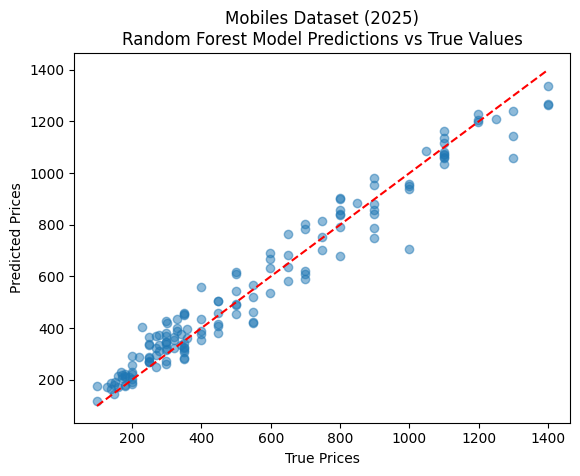

In [744]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Mobiles Dataset (2025)\nRandom Forest Model Predictions vs True Values")
plt.show()